In [31]:
!pip install emcee corner

In [32]:
import scipy as sp
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import corner

from scipy import integrate
from scipy.stats import norm
from scipy.stats import cauchy
from scipy.stats import norm, uniform
import emcee
import scipy.stats as stats

np.random.seed(104)

In [33]:
data = np.load('transient.npy')
data.shape

(100, 3)

In [34]:
data[:,0].shape

(100,)

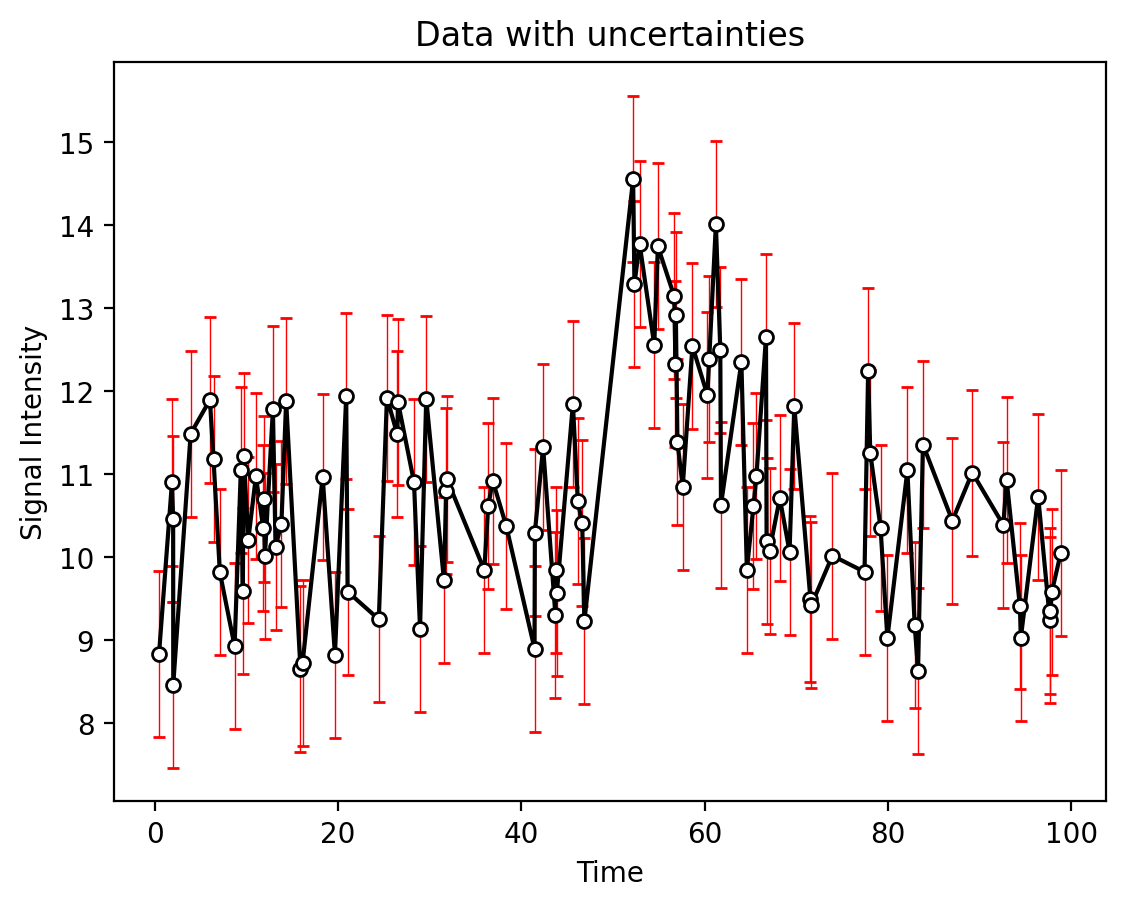

In [35]:
plt.errorbar(data[:,0], data[:,1], yerr=data[:,2], fmt='o-', color='black', ecolor='red', elinewidth=.5, capsize=2, markerfacecolor='white', markersize=5)
plt.title('Data with uncertainties')
plt.xlabel('Time')
plt.ylabel('Signal Intensity')
plt.show()

##Exponential Pulse

Relevant Functions

In [36]:
def burst_model(t, params):
  b, A, t0, alpha = params

  result = np.zeros_like(t, dtype=float)

  # Before burst: y = b
  mask_before = t < t0
  result[mask_before] = b

  # After burst: y = b + A*exp[-alpha*(t-t0)]
  mask_after = t >= t0
  result[mask_after] = b + A * np.exp(-alpha * (t[mask_after] - t0))

  return result

def log_likelihood(params, t, y, y_err):
    model = burst_model(t, params)

    return -0.5 * np.sum(((y - model) / y_err)**2 + np.log(2 * np.pi * y_err**2))

def log_prior(params):
    b, A, t0, log_alpha = params

    if 0 < b < 50 and 0 < A < 50 and 0 < t0 < 100 and -5 < log_alpha < 5:
        return 0.0
    return -np.inf

def log_posterior(params, t, y, y_err):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf

    b, A, t0, ln_alpha = params
    alpha = np.exp(ln_alpha)

    return lp + log_likelihood((b, A, t0, alpha), t, y, y_err)

In [37]:
t = data[:,0]
I = data[:,1]
yerr = data[:,2]

In [38]:
ndim = 4  # number of parameters in the model
nwalkers = 8  # number of MCMC walkers
nsteps = 200000  # number of MCMC steps to take **for each walker**

# initialize parameters
initial_b = uniform.rvs(loc=8, scale=5, size=nwalkers)
initial_A = uniform.rvs(loc=12, scale=5, size=nwalkers)
initial_t0 = uniform.rvs(loc=40, scale=20, size=nwalkers)
initial_ln_alpha = uniform.rvs(loc=-5, scale=10, size=nwalkers)


initial_positions = np.column_stack([initial_b, initial_A, initial_t0, initial_ln_alpha])

# MCMC
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_posterior, args=(t, I, yerr)
)
sampler.run_mcmc(initial_positions, nsteps, progress=True)


100%|██████████| 200000/200000 [03:09<00:00, 1054.57it/s]


State([[10.42858385  4.68446035 48.59002342 -2.16453317]
 [10.33834303  5.79734806 49.07225804 -2.00783496]
 [10.25749232  3.92831198 51.43778457 -2.30062496]
 [10.38152019  7.52079596 46.96626357 -1.99239295]
 [10.10548892  5.22878222 51.74698561 -2.01862147]
 [10.05457271  6.89077317 49.69146951 -2.0016896 ]
 [10.15699812  4.42135606 48.16024402 -2.44494437]
 [10.19329182  4.16187088 51.78929539 -2.37396593]], log_prob=[-142.06487023 -140.85629757 -140.99100114 -141.09139842 -143.75669867
 -144.3814176  -142.59226209 -142.17907686], blobs=None, random_state=('MT19937', array([3442120591, 2700533117, 1419960408, 1225353826, 2391716116,
        596851634, 1228981702, 2461676208,  609473685,  749634899,
        579761197, 1067137413, 1648597324,  792703683, 3920642908,
       1999370453, 1193883276, 3025710317, 1435758239,  529315224,
       2192492138, 2002515945, 3117522061, 3000240135, 4059492666,
        565351446, 2988879041, 1774081045,  250228765, 2496437601,
       3839464240, 3

In [39]:
def plot_chain(samples, labels):
  ndim = len(labels)
  plt.figure(figsize=(14, 10))
  for i, label in enumerate(labels):
    plt.subplot(ndim, 1, i+1)
    plt.plot(samples[:, :, i], alpha=0.3)
    plt.ylabel(label)
    plt.tight_layout()

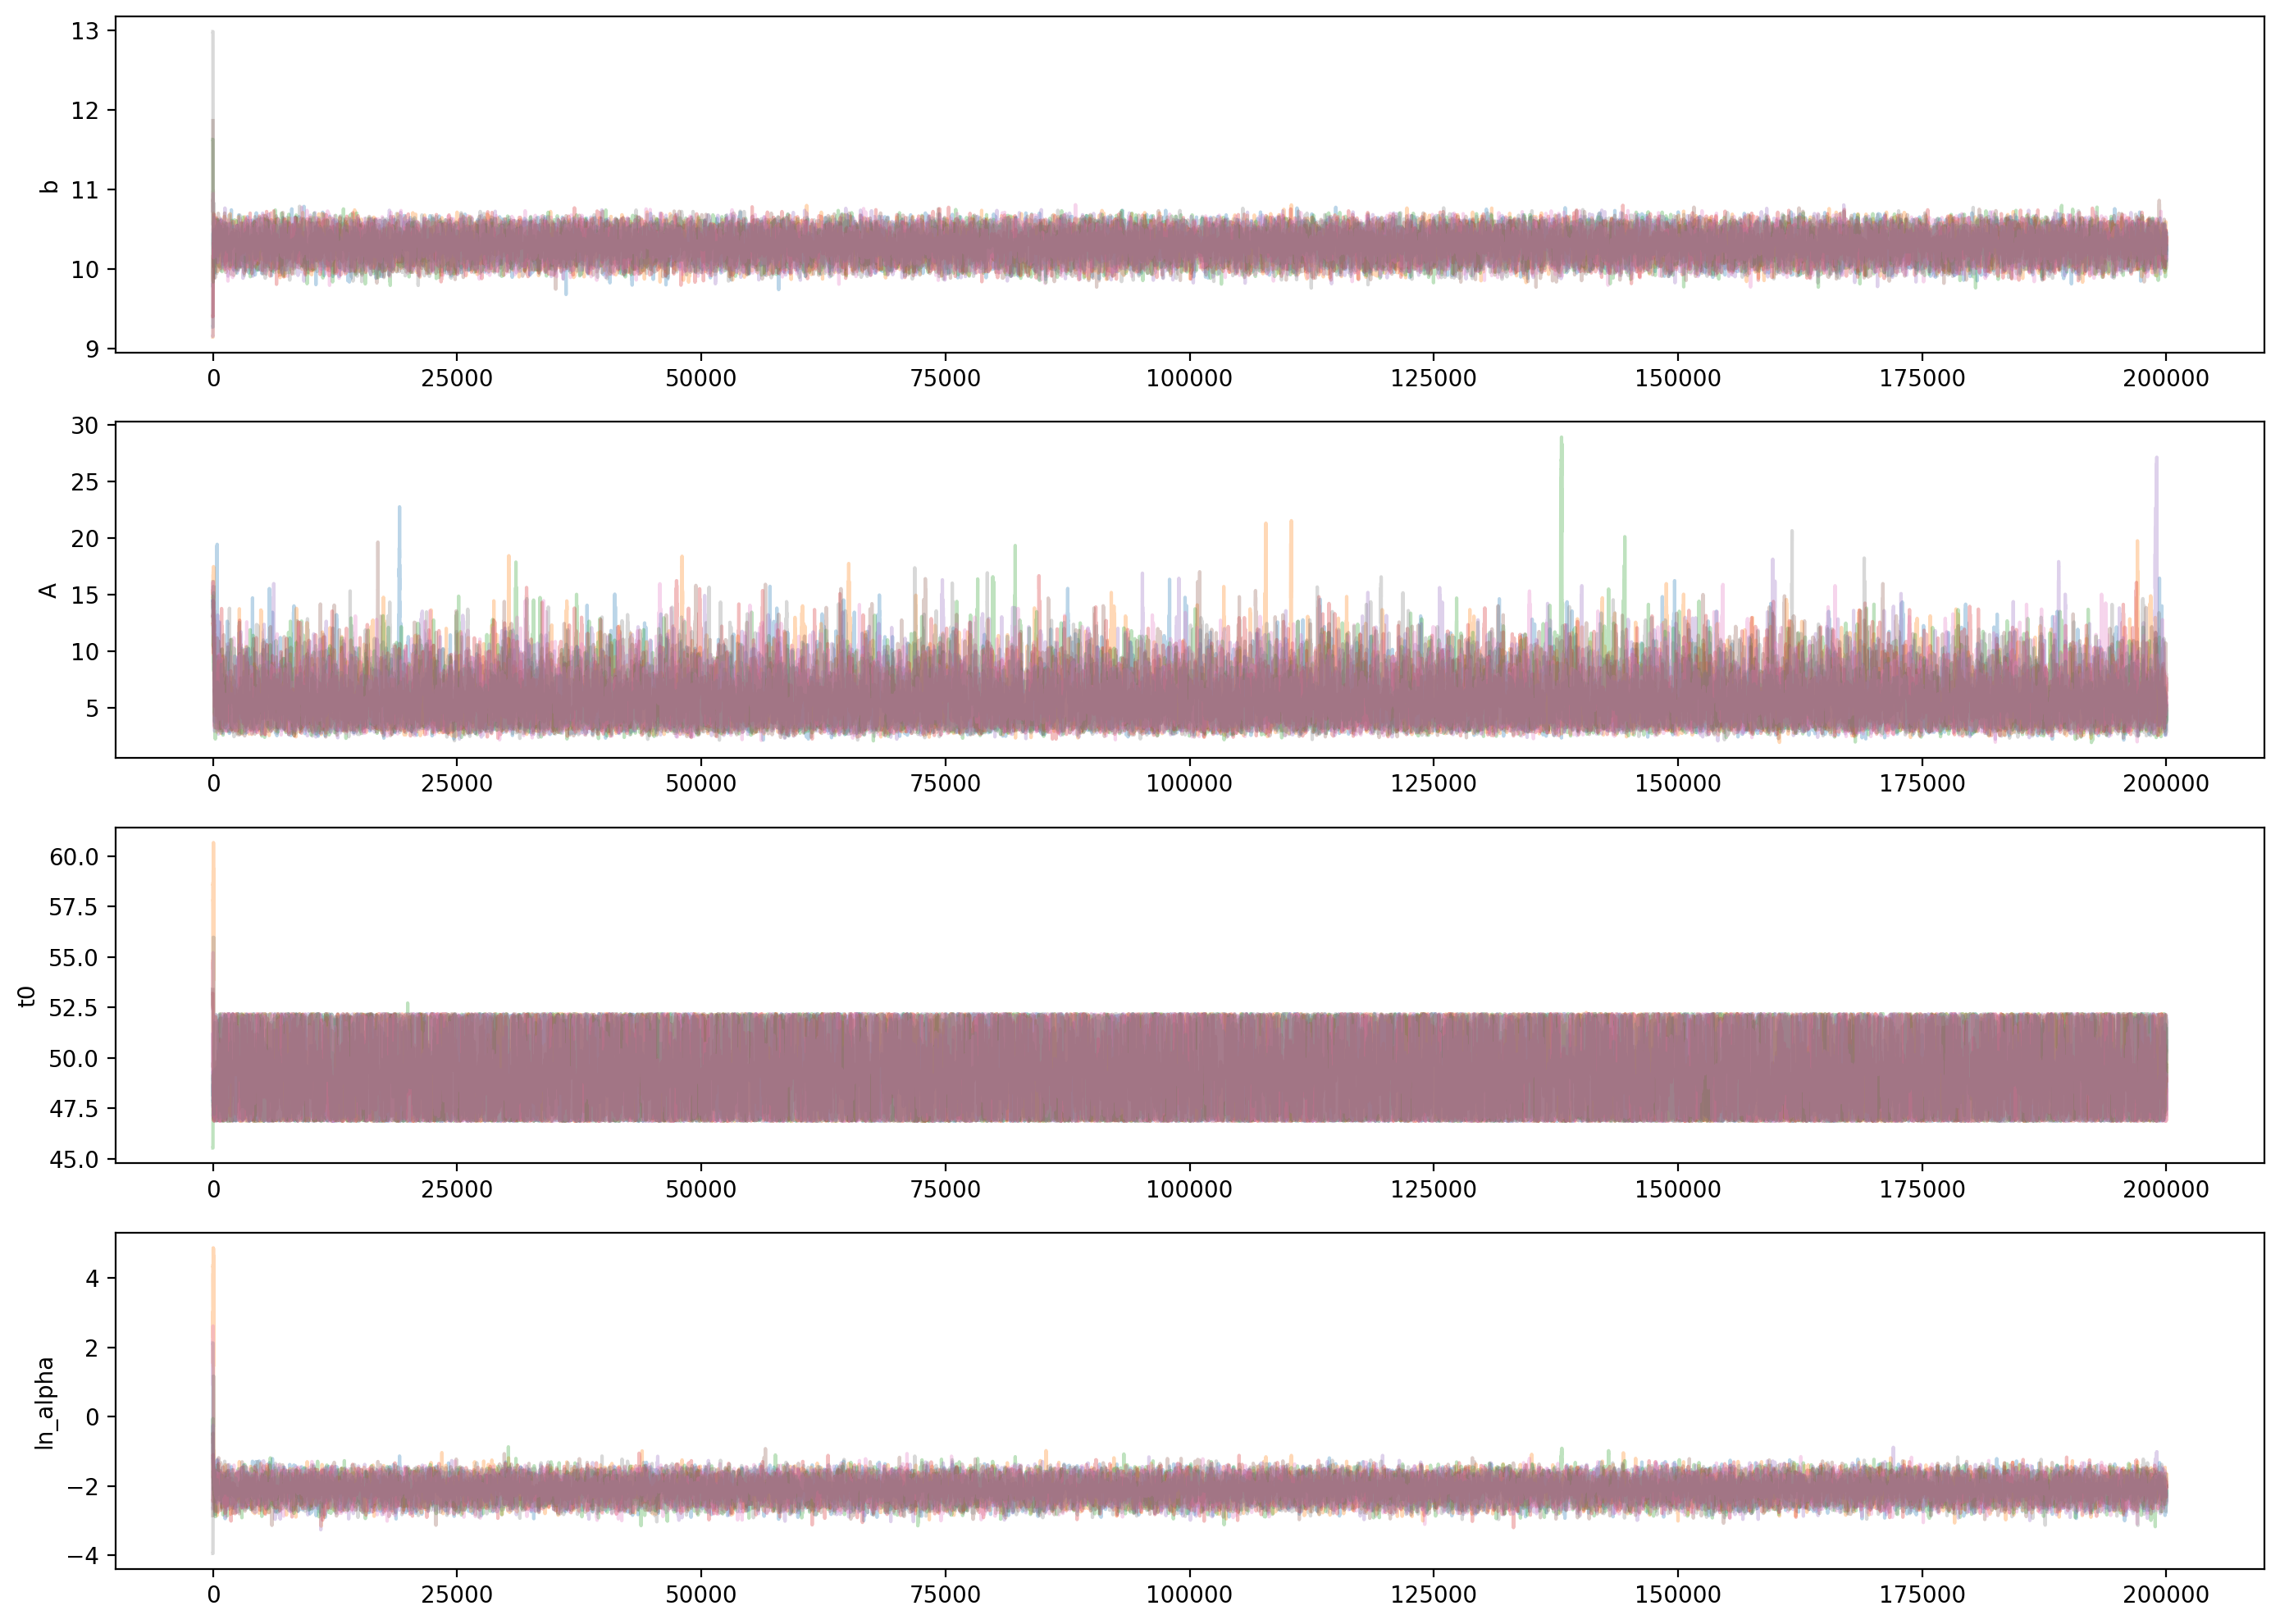

In [40]:
labels = ["b", "A", "t0", "ln_alpha"]
plot_chain(sampler.get_chain(), labels)

Autocorrelation Time/Burn-in

In [41]:
tau = sampler.get_autocorr_time()
print(f"Autocorrelation times: {tau}")
burnin = 52000
thin = int(np.max(tau) / 2)

print(f"Burn-in: {burnin} steps")
print(f"Thin: {thin} steps")

Autocorrelation times: [ 75.02233147 104.55954466  99.3663532   83.19539802]
Burn-in: 52000 steps
Thin: 52 steps


In [42]:
samples = sampler.get_chain(discard=burnin, thin=thin, flat=True)
print(f"Number of samples after burn-in and thinning: {len(samples)}")

Number of samples after burn-in and thinning: 22768


In [43]:
def plot_chain_flattened(chain, labels):
  ndim = len(labels)
  plt.figure(figsize=(14, 10))
  for i, label in enumerate(labels):
    plt.subplot(ndim, 1, i+1)
    plt.plot(samples[:, i], alpha=0.3)
    plt.ylabel(label)
    plt.tight_layout()

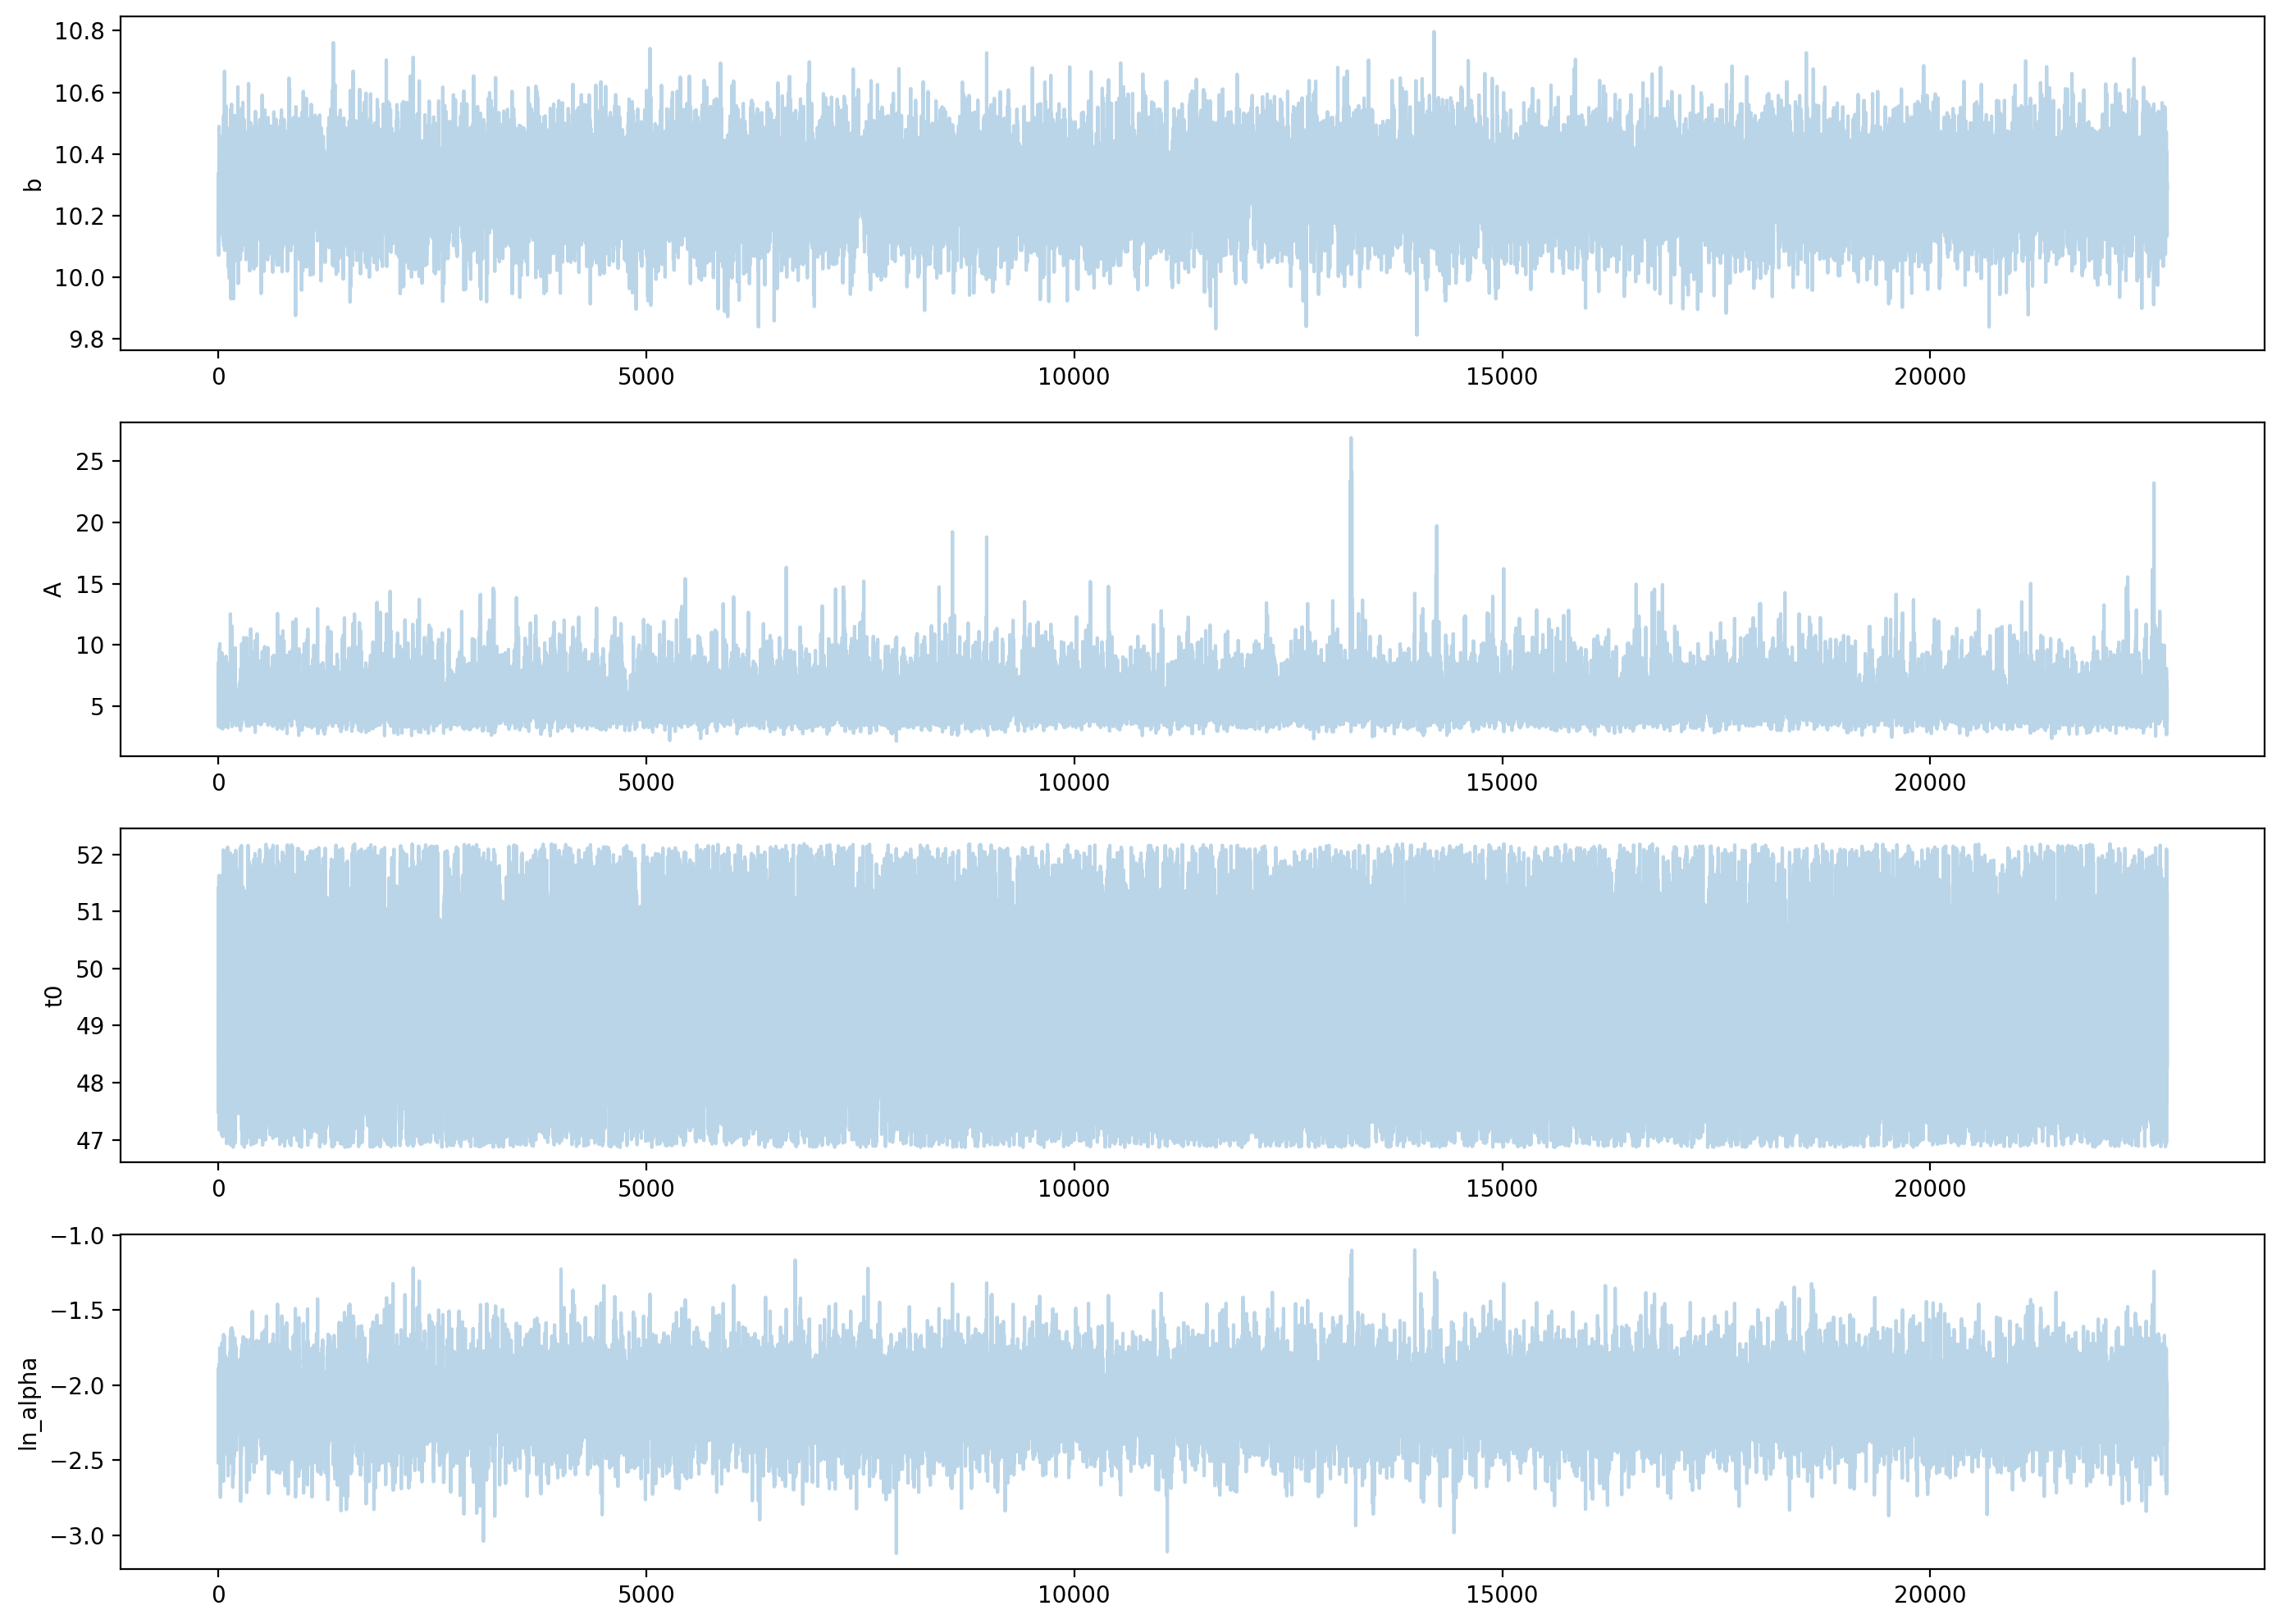

In [44]:
plot_chain_flattened(samples, labels)

Plot 10 random sample curves from the posterior

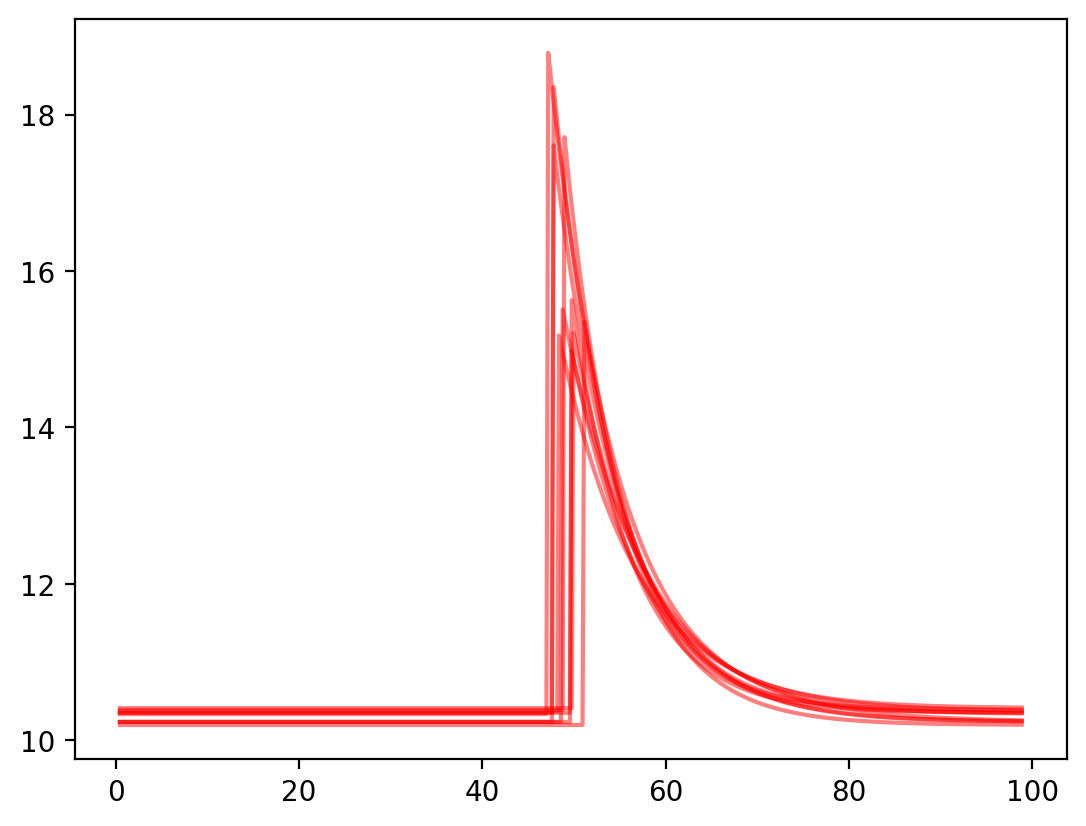

In [45]:
random_indices = np.random.randint(0, len(samples), 10)
t_model = np.linspace(min(t), max(t), 500)
for idx in random_indices:
    params = samples[idx]
    params[3] = np.exp(params[3])  # Convert ln_alpha back to alpha
    plt.plot(t_model, burst_model(t_model, params), alpha=0.5, color='red')

Corner Plot

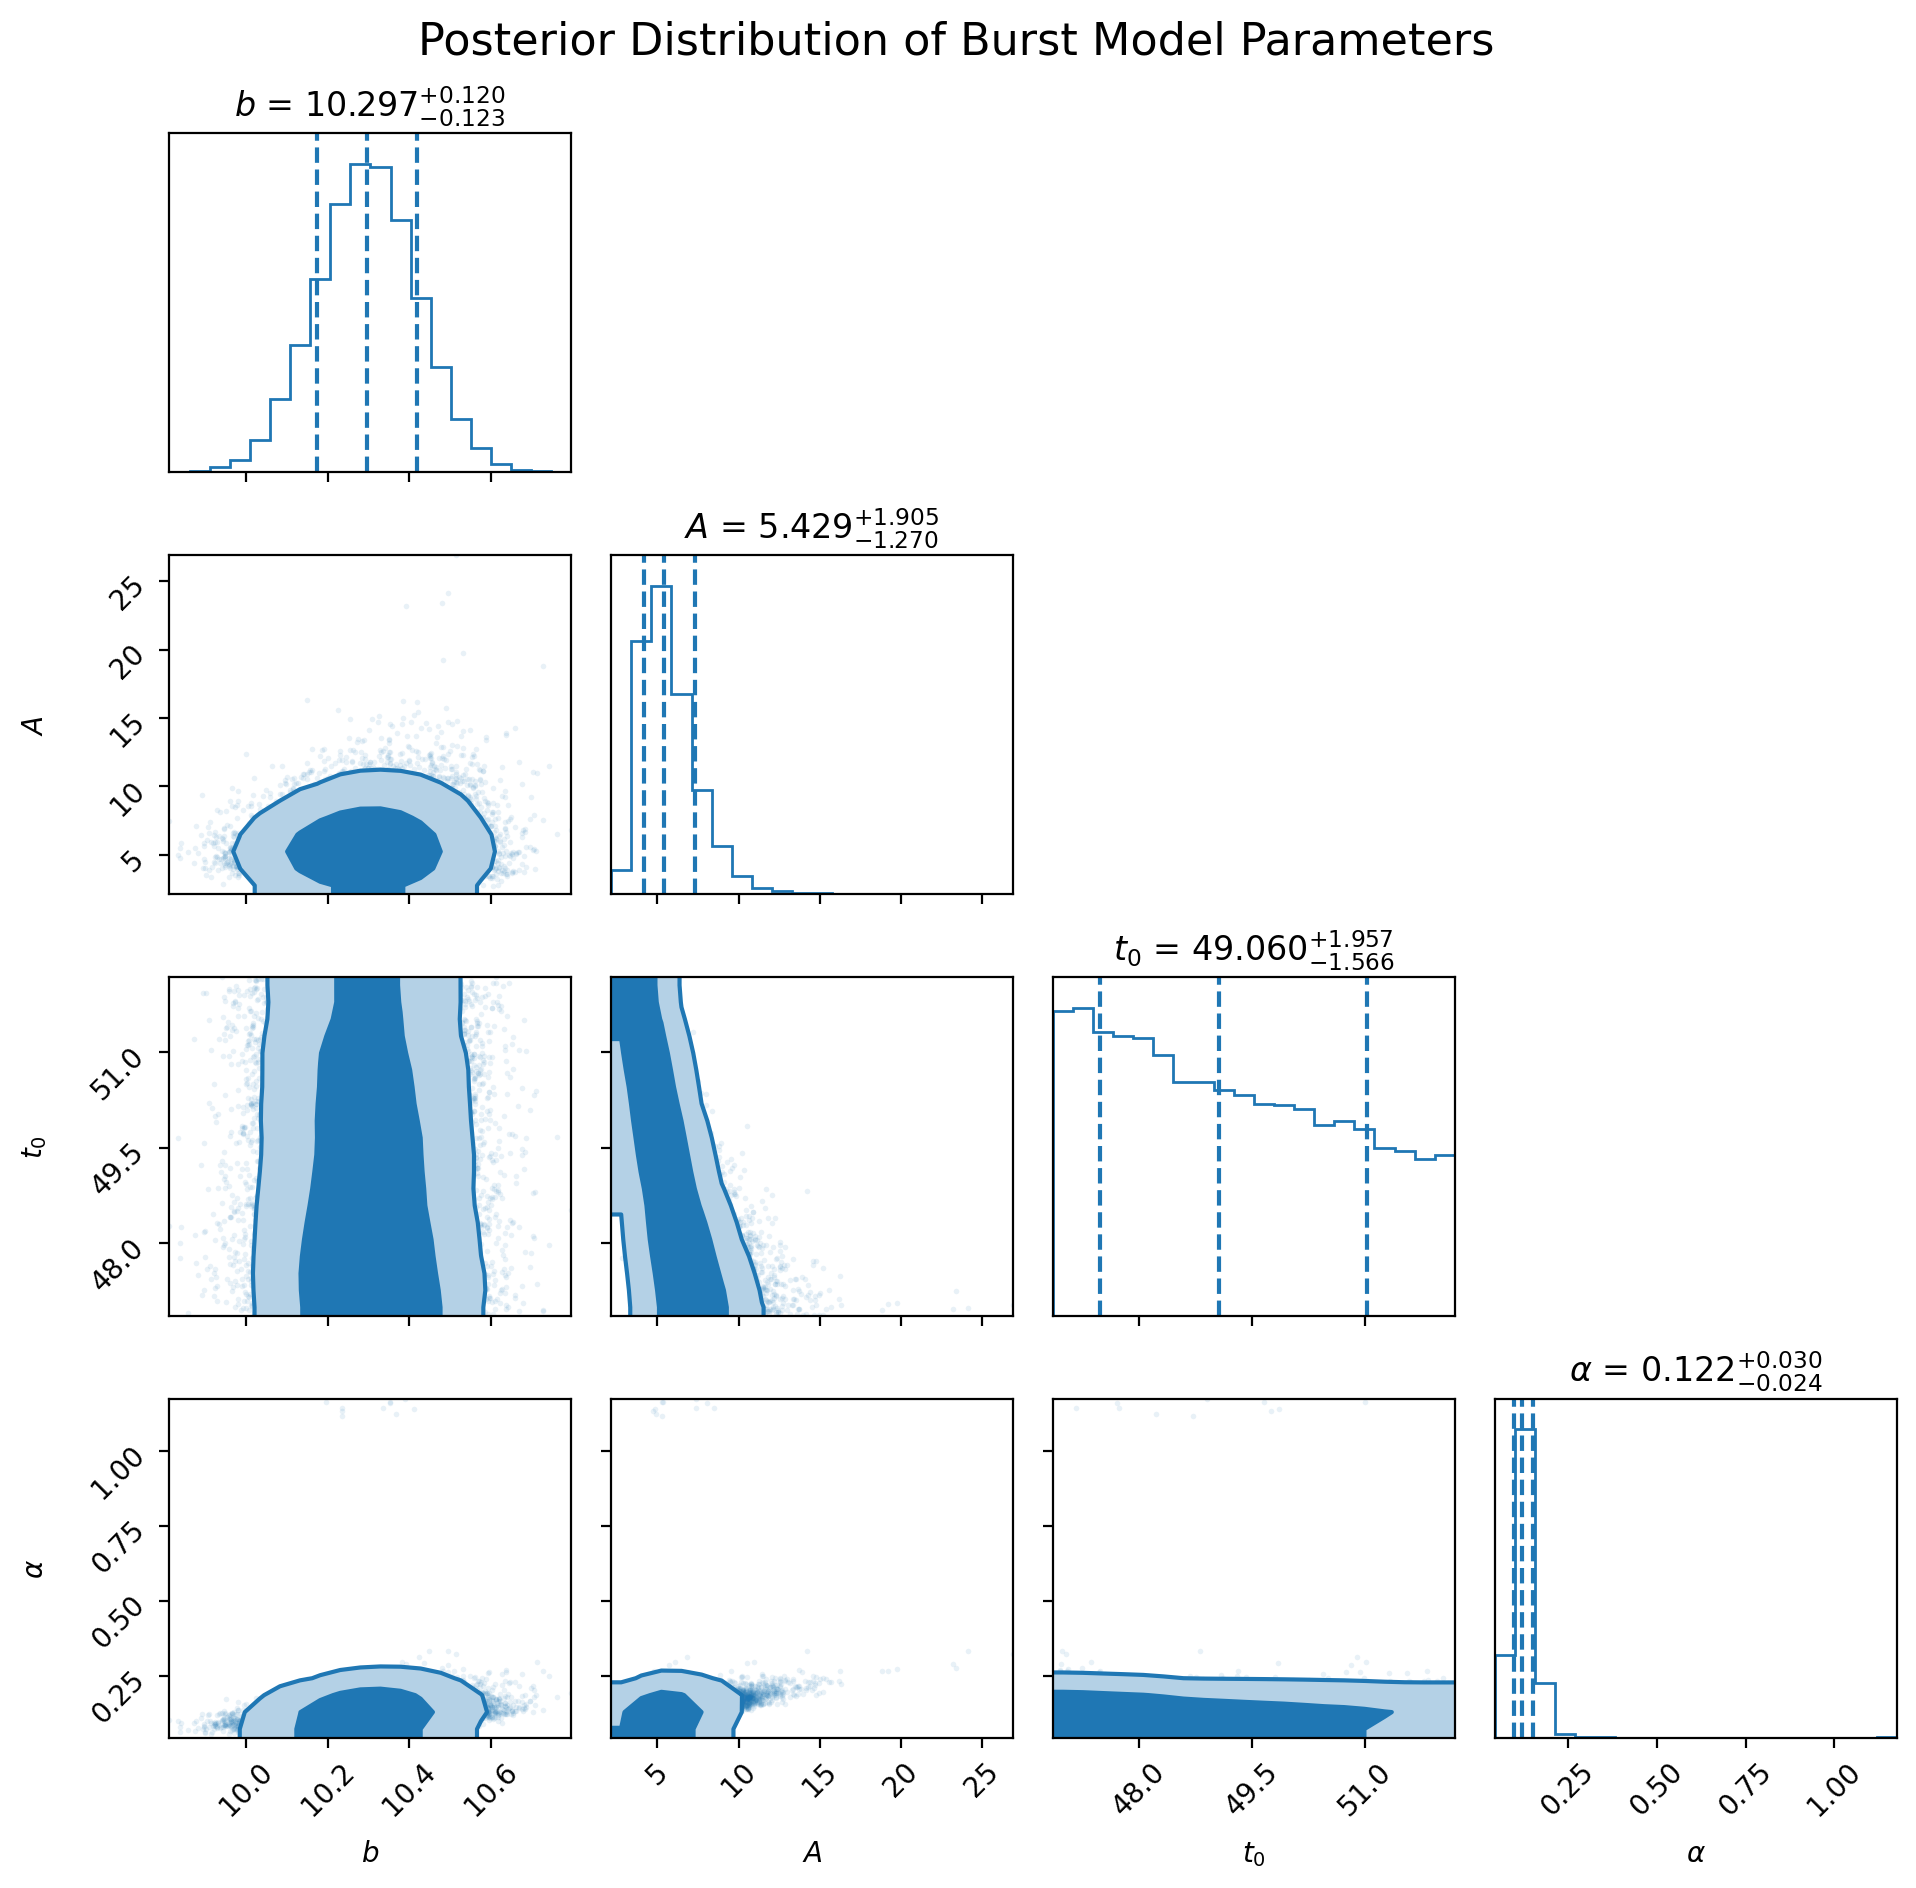

In [46]:
labels = [r"$b$", r"$A$", r"$t_0$", r"$\alpha$"]

samples_with_alpha = samples.copy()
samples_with_alpha[:, 3] = np.exp(samples_with_alpha[:, 3])

fig = corner.corner(
    samples_with_alpha,
    labels=labels,
    quantiles=[0.16, 0.5, 0.84],  # 16%, 50% (median), and 84% quantiles
    show_titles=True,
    title_kwargs={"fontsize": 12},
    title_fmt=".3f",
    levels=[0.68, 0.95],  # 68% and 95% credible levels
    smooth=1.0,
    plot_datapoints=True,
    plot_density=True,
    fill_contours=True,
    color='#1f77b4',
  )

fig.suptitle("Posterior Distribution of Burst Model Parameters", fontsize=16)
plt.tight_layout()

Plot 100 burst time series

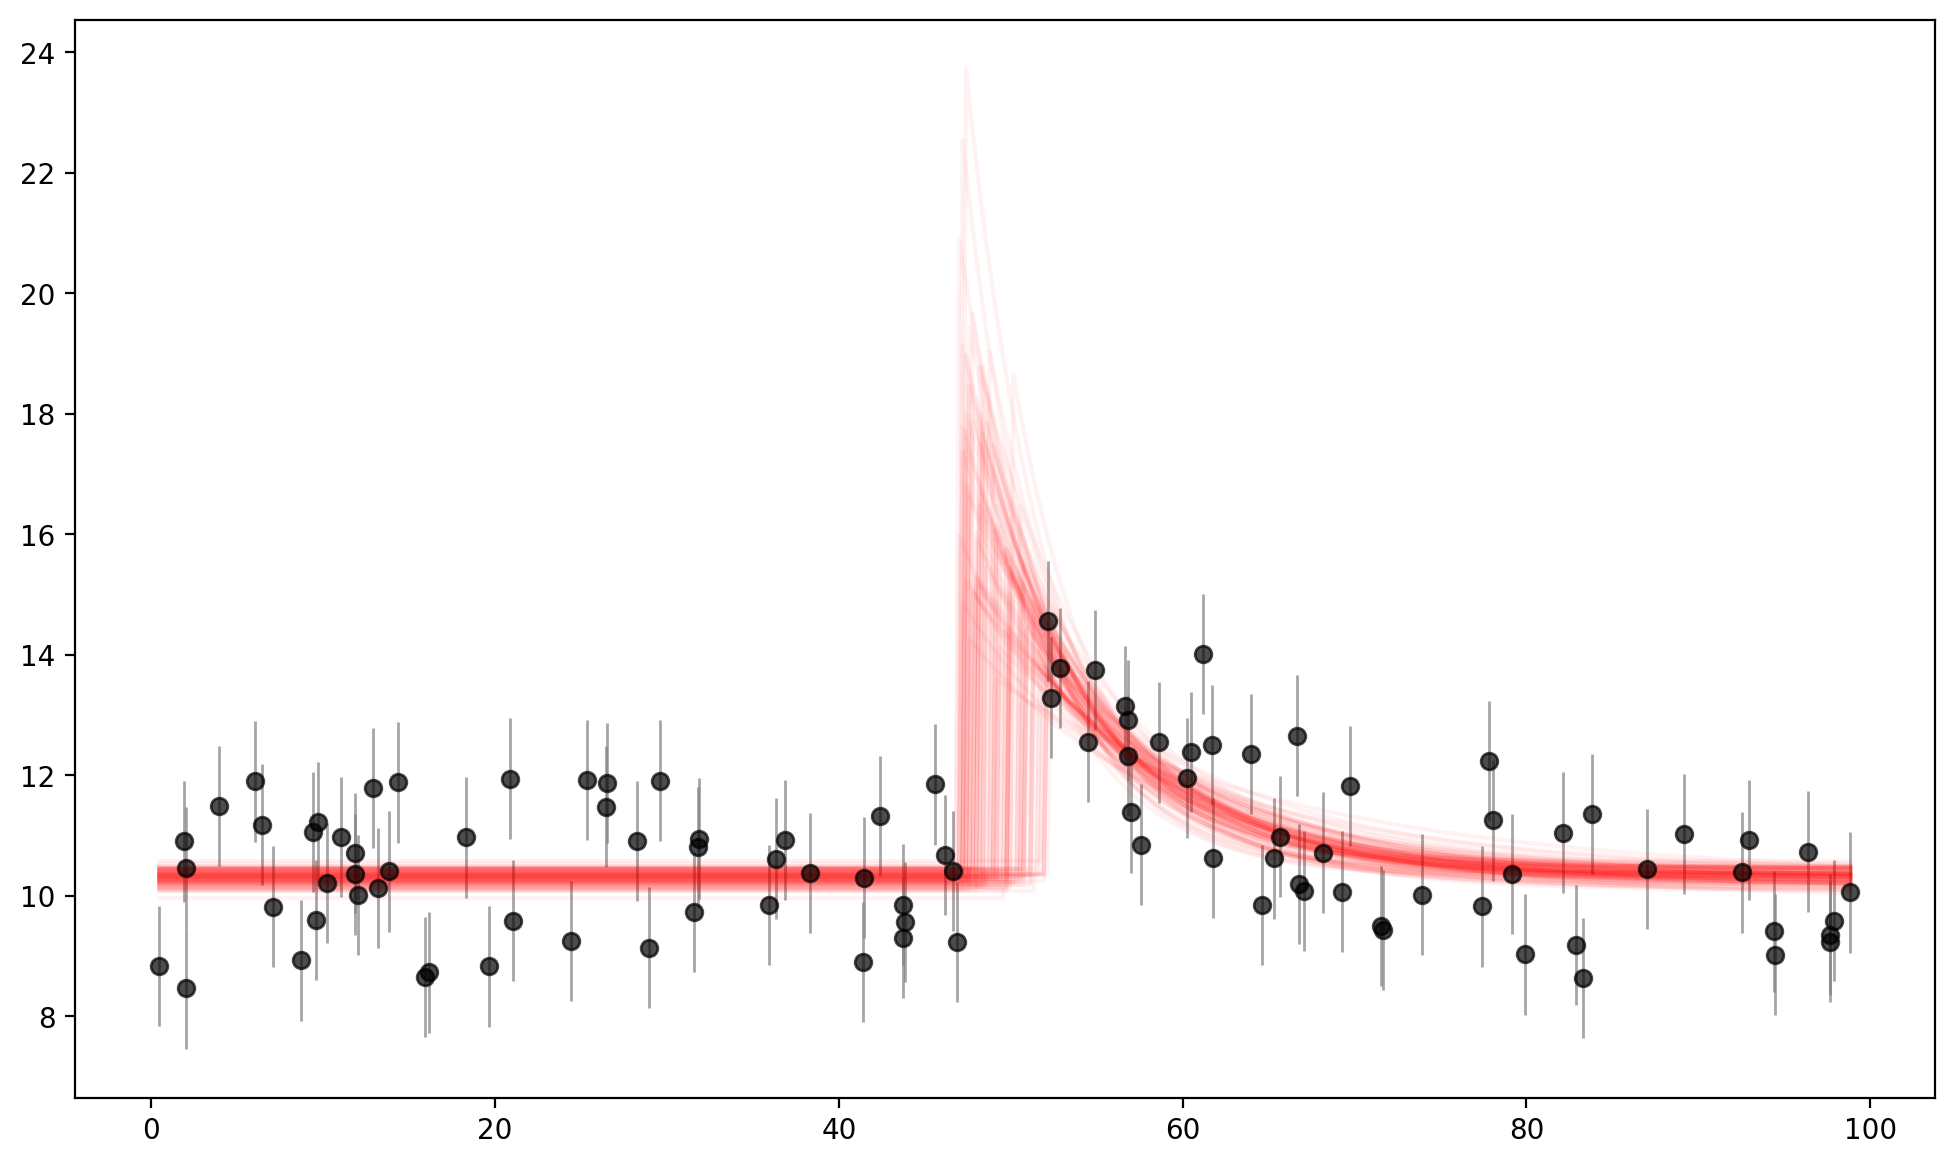

In [47]:
np.random.seed(6)
random_indices = np.random.choice(len(samples), 100, replace=False)

# Create a figure with a specific size
plt.figure(figsize=(12, 7))

# Plot the original data points with error bars
plt.errorbar(t, I, yerr=yerr, fmt='o', color='black',
             ecolor='gray', elinewidth=1, capsize=0, alpha=0.7,
             label='Data with uncertainties')

# Plot 100 model curves from the posterior samples
for idx in random_indices:
    params = samples_with_alpha[idx].copy()
    model_intensity = burst_model(t_model, params)
    plt.plot(t_model, model_intensity, color='red', alpha=0.05)

# Add a single red line for the legend
plt.plot([], [], color='red', alpha=0.5, label='Posterior model samples')

Median and 90% credible region of the marginalized distribution

In [48]:
def calculate_credible_region(samples, parameter_name):
  # Calculate the 5th, 50th, and 95th percentiles
  p5, p50, p95 = np.percentile(samples, [5, 50, 95])

  # Format and print the results
  print(f"{parameter_name} = {p50:.3f}_{{-{p50-p5:.3f}}}^{{+{p95-p50:.3f}}}")

  return p50, p5, p95

In [49]:
b_median, b_lower, b_upper = calculate_credible_region(samples[:, 0], "b")
A_median, A_lower, A_upper = calculate_credible_region(samples[:, 1], "A")
t0_median, t0_lower, t0_upper = calculate_credible_region(samples[:, 2], "t0")
alpha_median, alpha_lower, alpha_upper = calculate_credible_region(samples_with_alpha[:, 3], "alpha")

b = 10.297_{-0.204}^{+0.199}
A = 5.429_{-1.824}^{+3.494}
t0 = 49.060_{-2.004}^{+2.752}
alpha = 0.122_{-0.037}^{+0.054}


##Gaussian Pulse

In [50]:
def gaussian_model(t, params):
  b, A, t0, sigma_w = params

  return b + A * np.exp(-(t - t0)**2 / (2 * sigma_w**2))

def log_likelihood_gaussian(params, t, y, y_err):
    model = gaussian_model(t, params)

    return -0.5 * np.sum(((y - model) / y_err)**2 + np.log(2 * np.pi * y_err**2))

def log_prior_gaussian(params):
    b, A, t0, ln_sigma_w = params

    if 0 < b < 50 and 0 < A < 50 and 0 < t0 < 100 and -5 < ln_sigma_w < 5:
        return 0.0
    return -np.inf

def log_posterior_gaussian(params, t, y, y_err):
    lp = log_prior_gaussian(params)

    if not np.isfinite(lp):
        return -np.inf

    b, A, t0, ln_sigma_w = params
    sigma_w = np.exp(ln_sigma_w)

    return lp + log_likelihood_gaussian((b, A, t0, sigma_w), t, y, y_err)

In [51]:
n_dim_gaussian = 4
n_walkers_gaussian = 8
nsteps_gaussian = 200000

#Initial guesses
initial_b = uniform.rvs(loc=10, scale=20, size=n_walkers_gaussian)
initial_A = uniform.rvs(loc=0, scale=7, size=n_walkers_gaussian)
initial_t0 = uniform.rvs(loc=40, scale=30, size=n_walkers_gaussian)
initial_ln_sigma_w = uniform.rvs(loc=0, scale=3, size=n_walkers_gaussian)

initial_positions_gaussian = np.column_stack([initial_b, initial_A, initial_t0, initial_ln_sigma_w])

sampler_gaussian = emcee.EnsembleSampler(
    n_walkers_gaussian, n_dim_gaussian, log_posterior_gaussian,
    args=(t, I, yerr))

sampler_gaussian.run_mcmc(initial_positions_gaussian, nsteps_gaussian, progress=True)

100%|██████████| 200000/200000 [02:40<00:00, 1243.46it/s]


State([[10.44228391  2.59085563 55.50145771  1.49606332]
 [10.18756169  3.16440122 55.98735712  1.8074062 ]
 [10.14612667  3.1209375  53.67254072  1.74536721]
 [10.27553233  3.03681782 54.6909292   1.60559726]
 [10.33959241  2.13947963 56.24460214  1.92234673]
 [10.38456169  2.23681958 54.13114969  1.79369603]
 [10.30468281  2.40533498 55.90230134  1.82428517]
 [10.3516068   2.97875394 54.92503334  1.3272503 ]], log_prob=[-145.51044074 -146.25964966 -147.80113457 -144.81700066 -146.46157243
 -147.08056299 -145.00220987 -146.65795421], blobs=None, random_state=('MT19937', array([2531081275, 4288749801, 3274313086,  761299586,  428170313,
       1765267710, 4008372073, 1506077738, 2309844256,  630362585,
       4156962600,  695382550, 3643309446, 4268763278, 2539306776,
       1311523731,  307551589, 2082152442,  302985082,   10618326,
       4175848888, 1091759945, 1891617987, 1371288588, 2440852880,
       4125461921,  241596614, 3176300628,  334447656, 1027767840,
       4261449972, 2

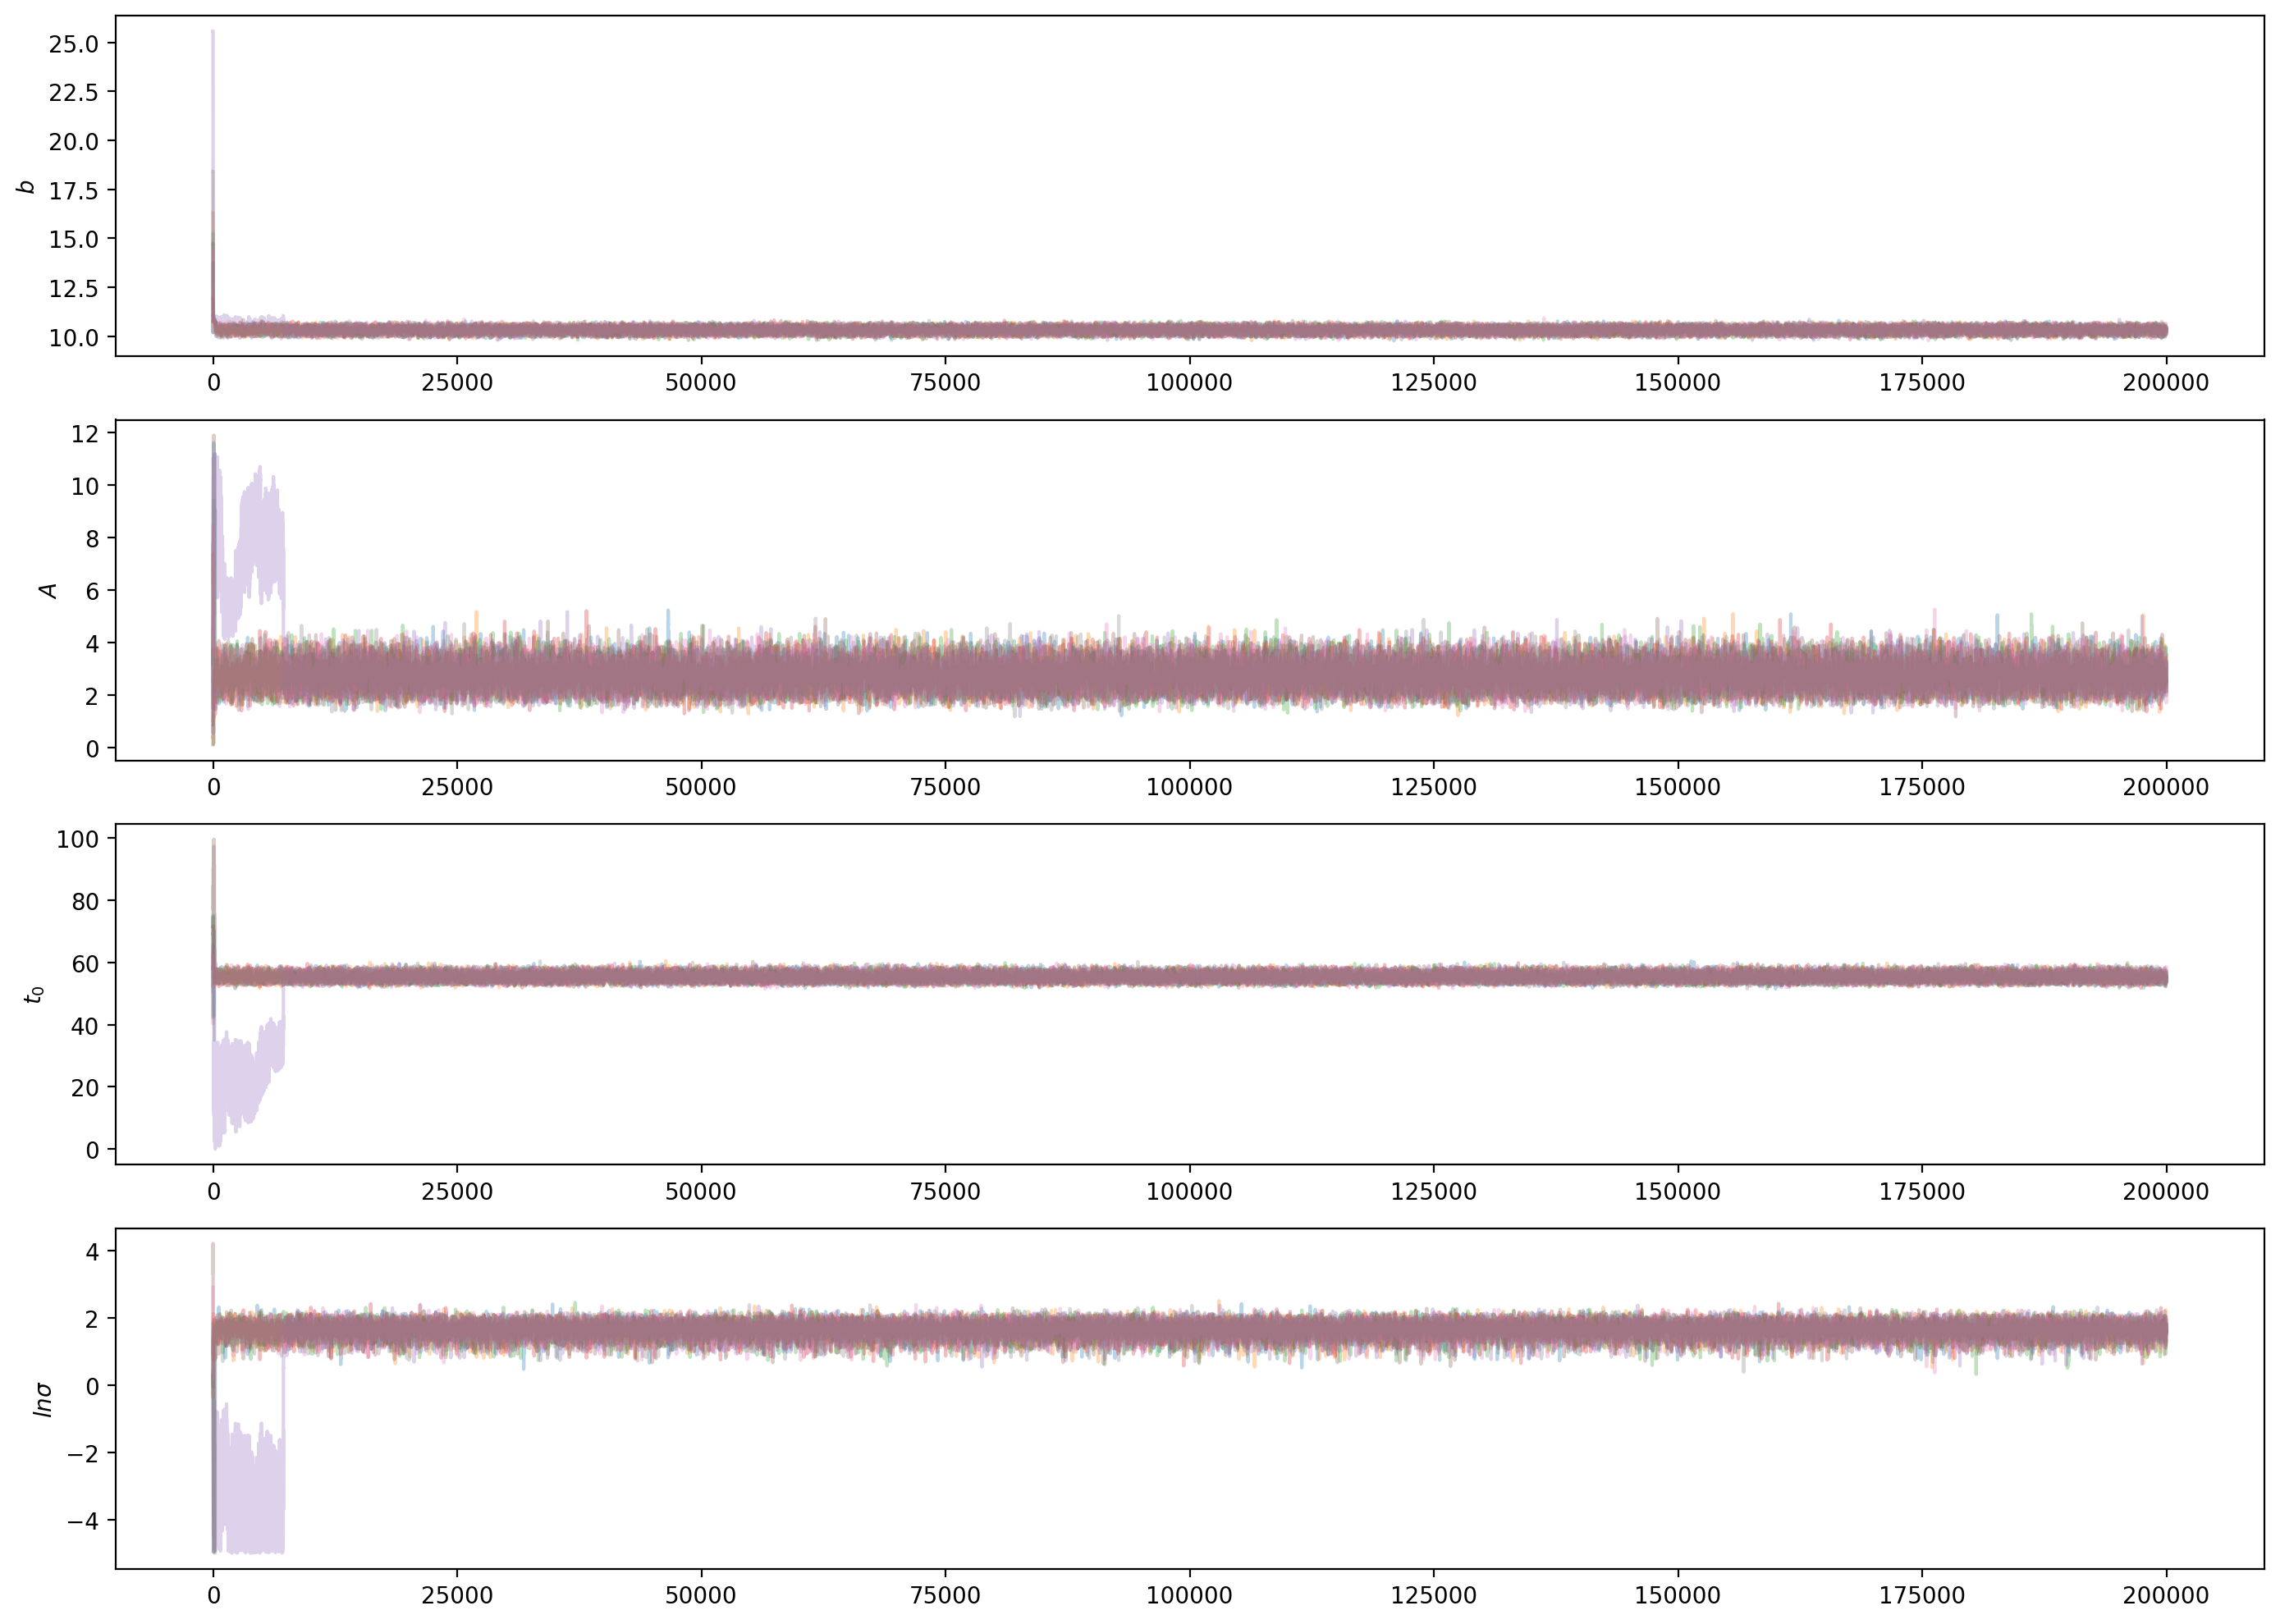

In [52]:
labels_gaussian = [r"$b$", r"$A$", r"$t_0$", r"$ln\sigma$"]
plot_chain(sampler_gaussian.get_chain(), labels_gaussian)

In [53]:
tau = sampler_gaussian.get_autocorr_time()
print(f"Autocorrelation times: {tau}")
burnin_gaussian = 40000
thin_gaussian = int(np.max(tau) / 2)

print(f"Burn-in: {burnin_gaussian} steps")
print(f"Thin: {thin_gaussian} steps")

Autocorrelation times: [ 87.67480809 427.97031814 666.35908394 713.56935704]
Burn-in: 40000 steps
Thin: 356 steps


In [54]:
samples_gaussian = sampler_gaussian.get_chain(discard=burnin_gaussian, thin=thin_gaussian, flat=True)
print(f"Number of samples after burn-in and thinning: {len(samples_gaussian)}")

Number of samples after burn-in and thinning: 3592


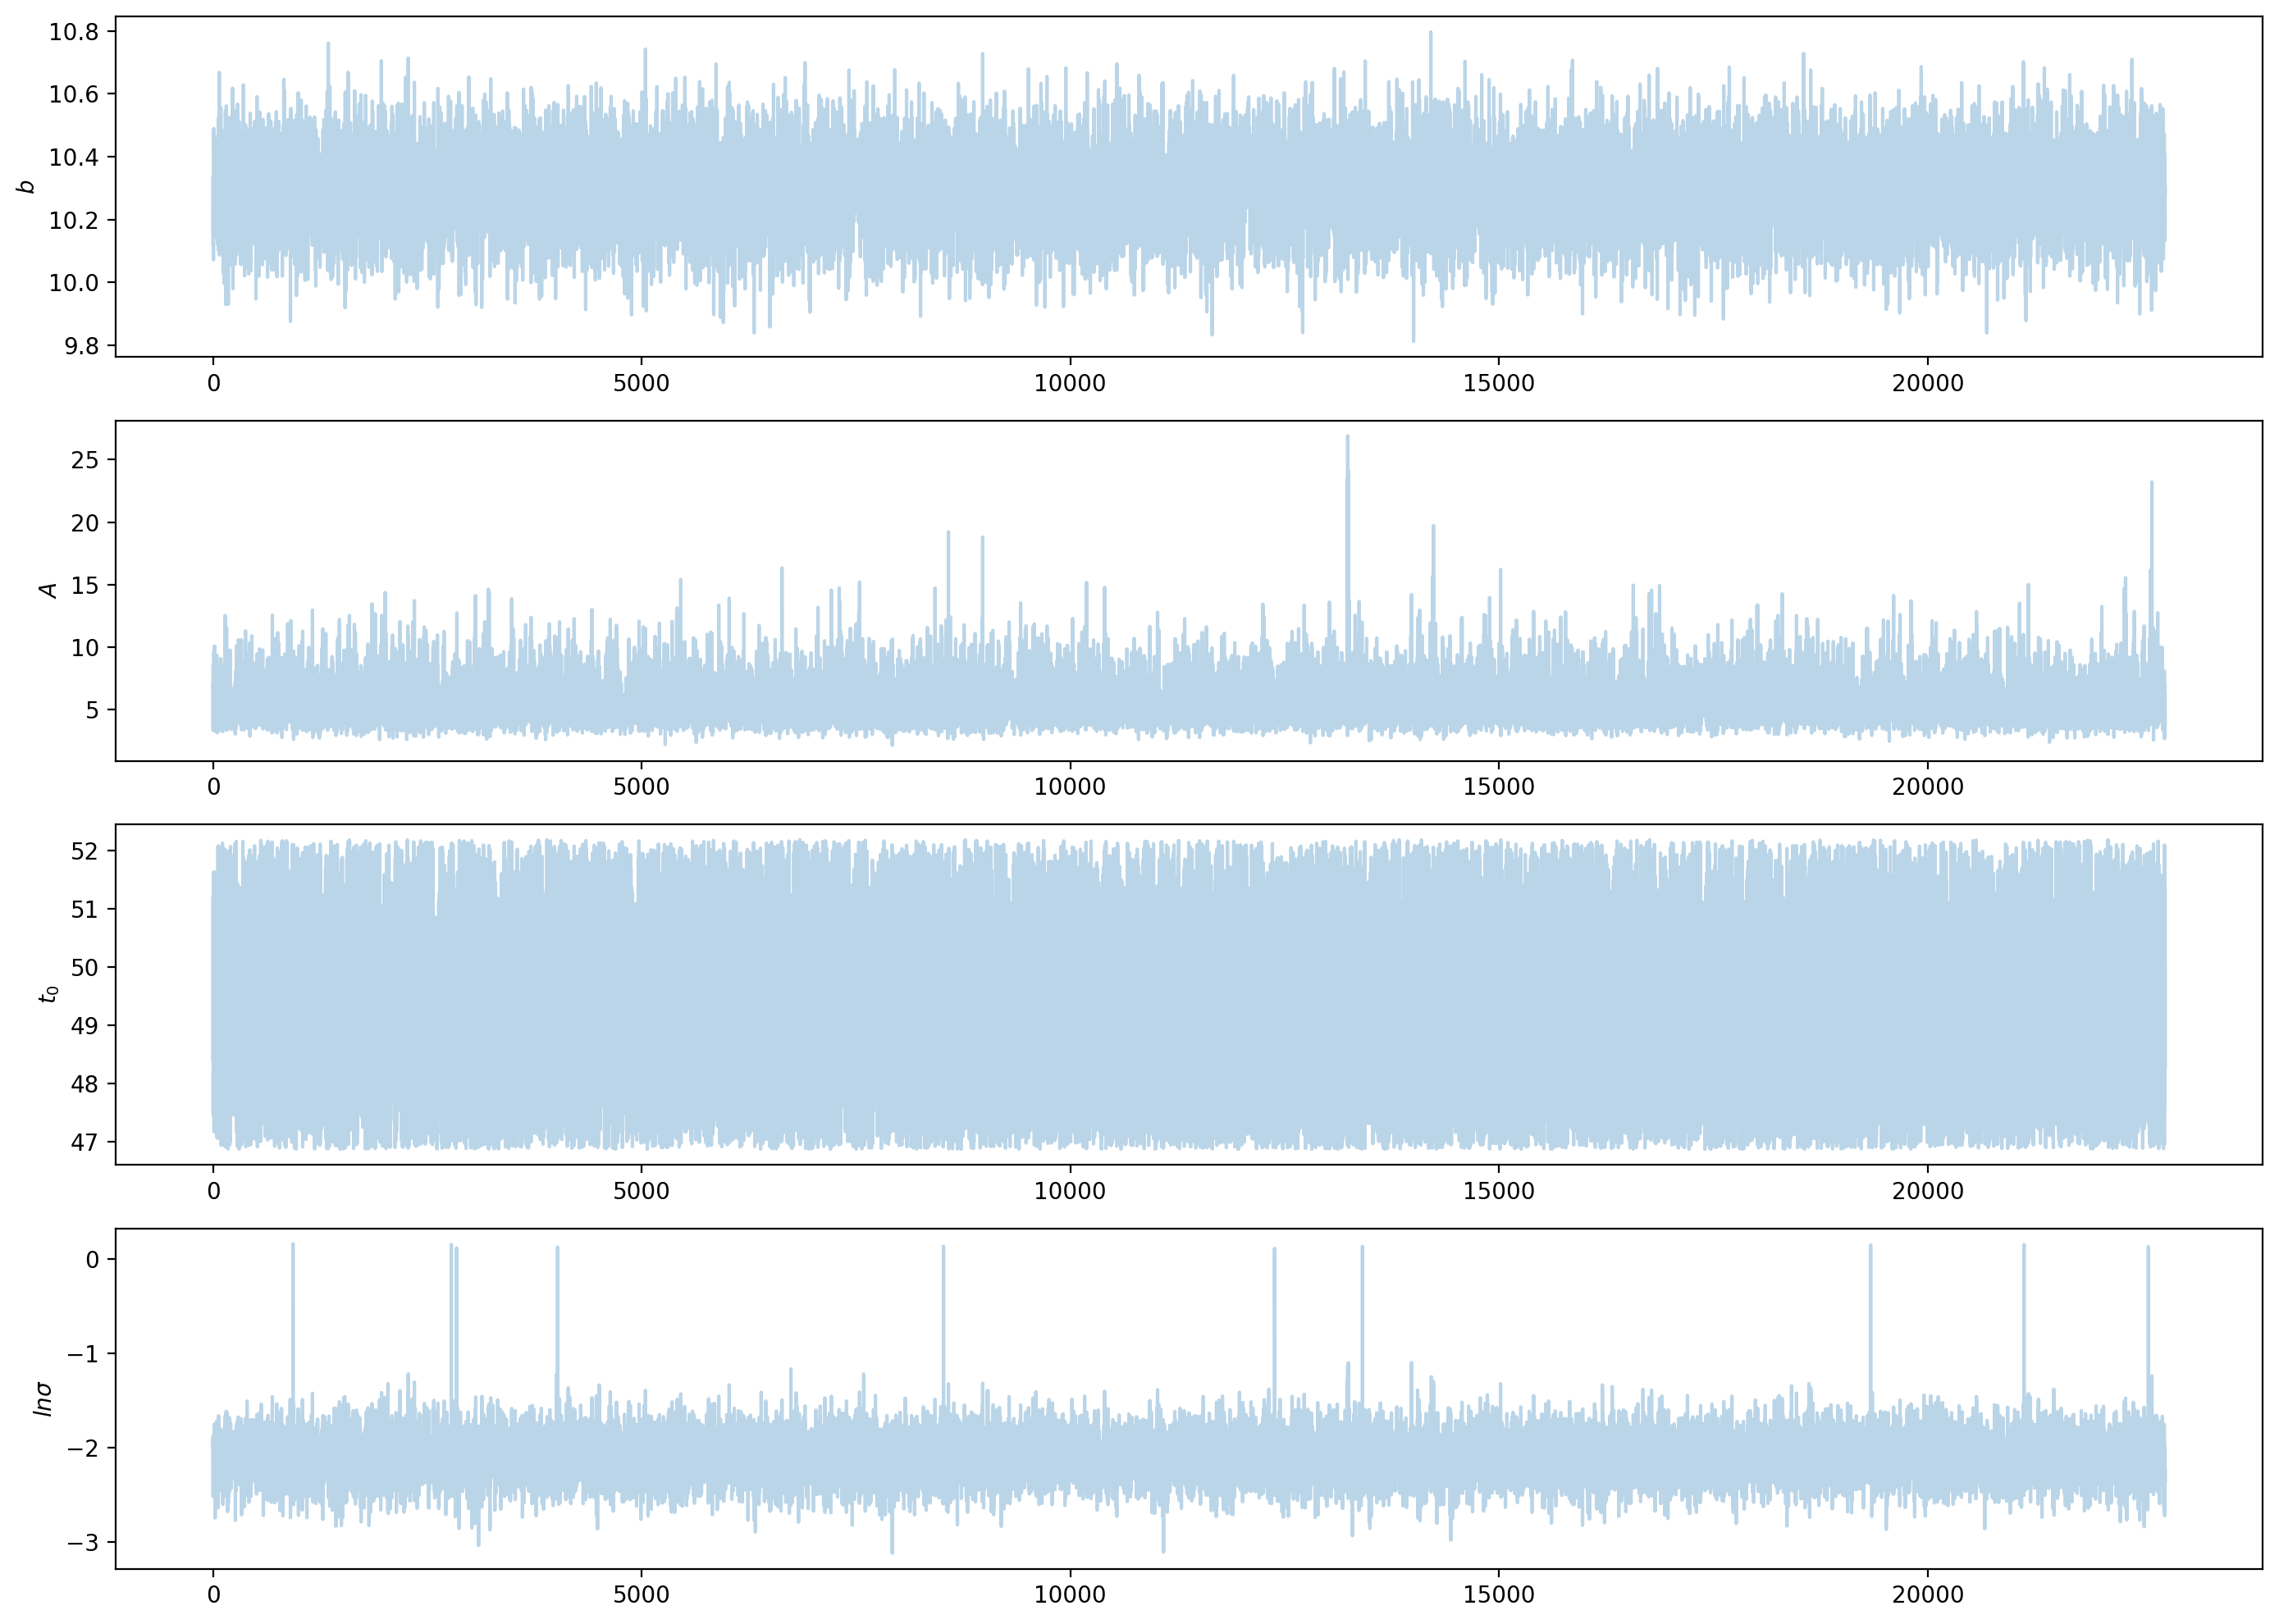

In [55]:
plot_chain_flattened(samples_gaussian, labels_gaussian)

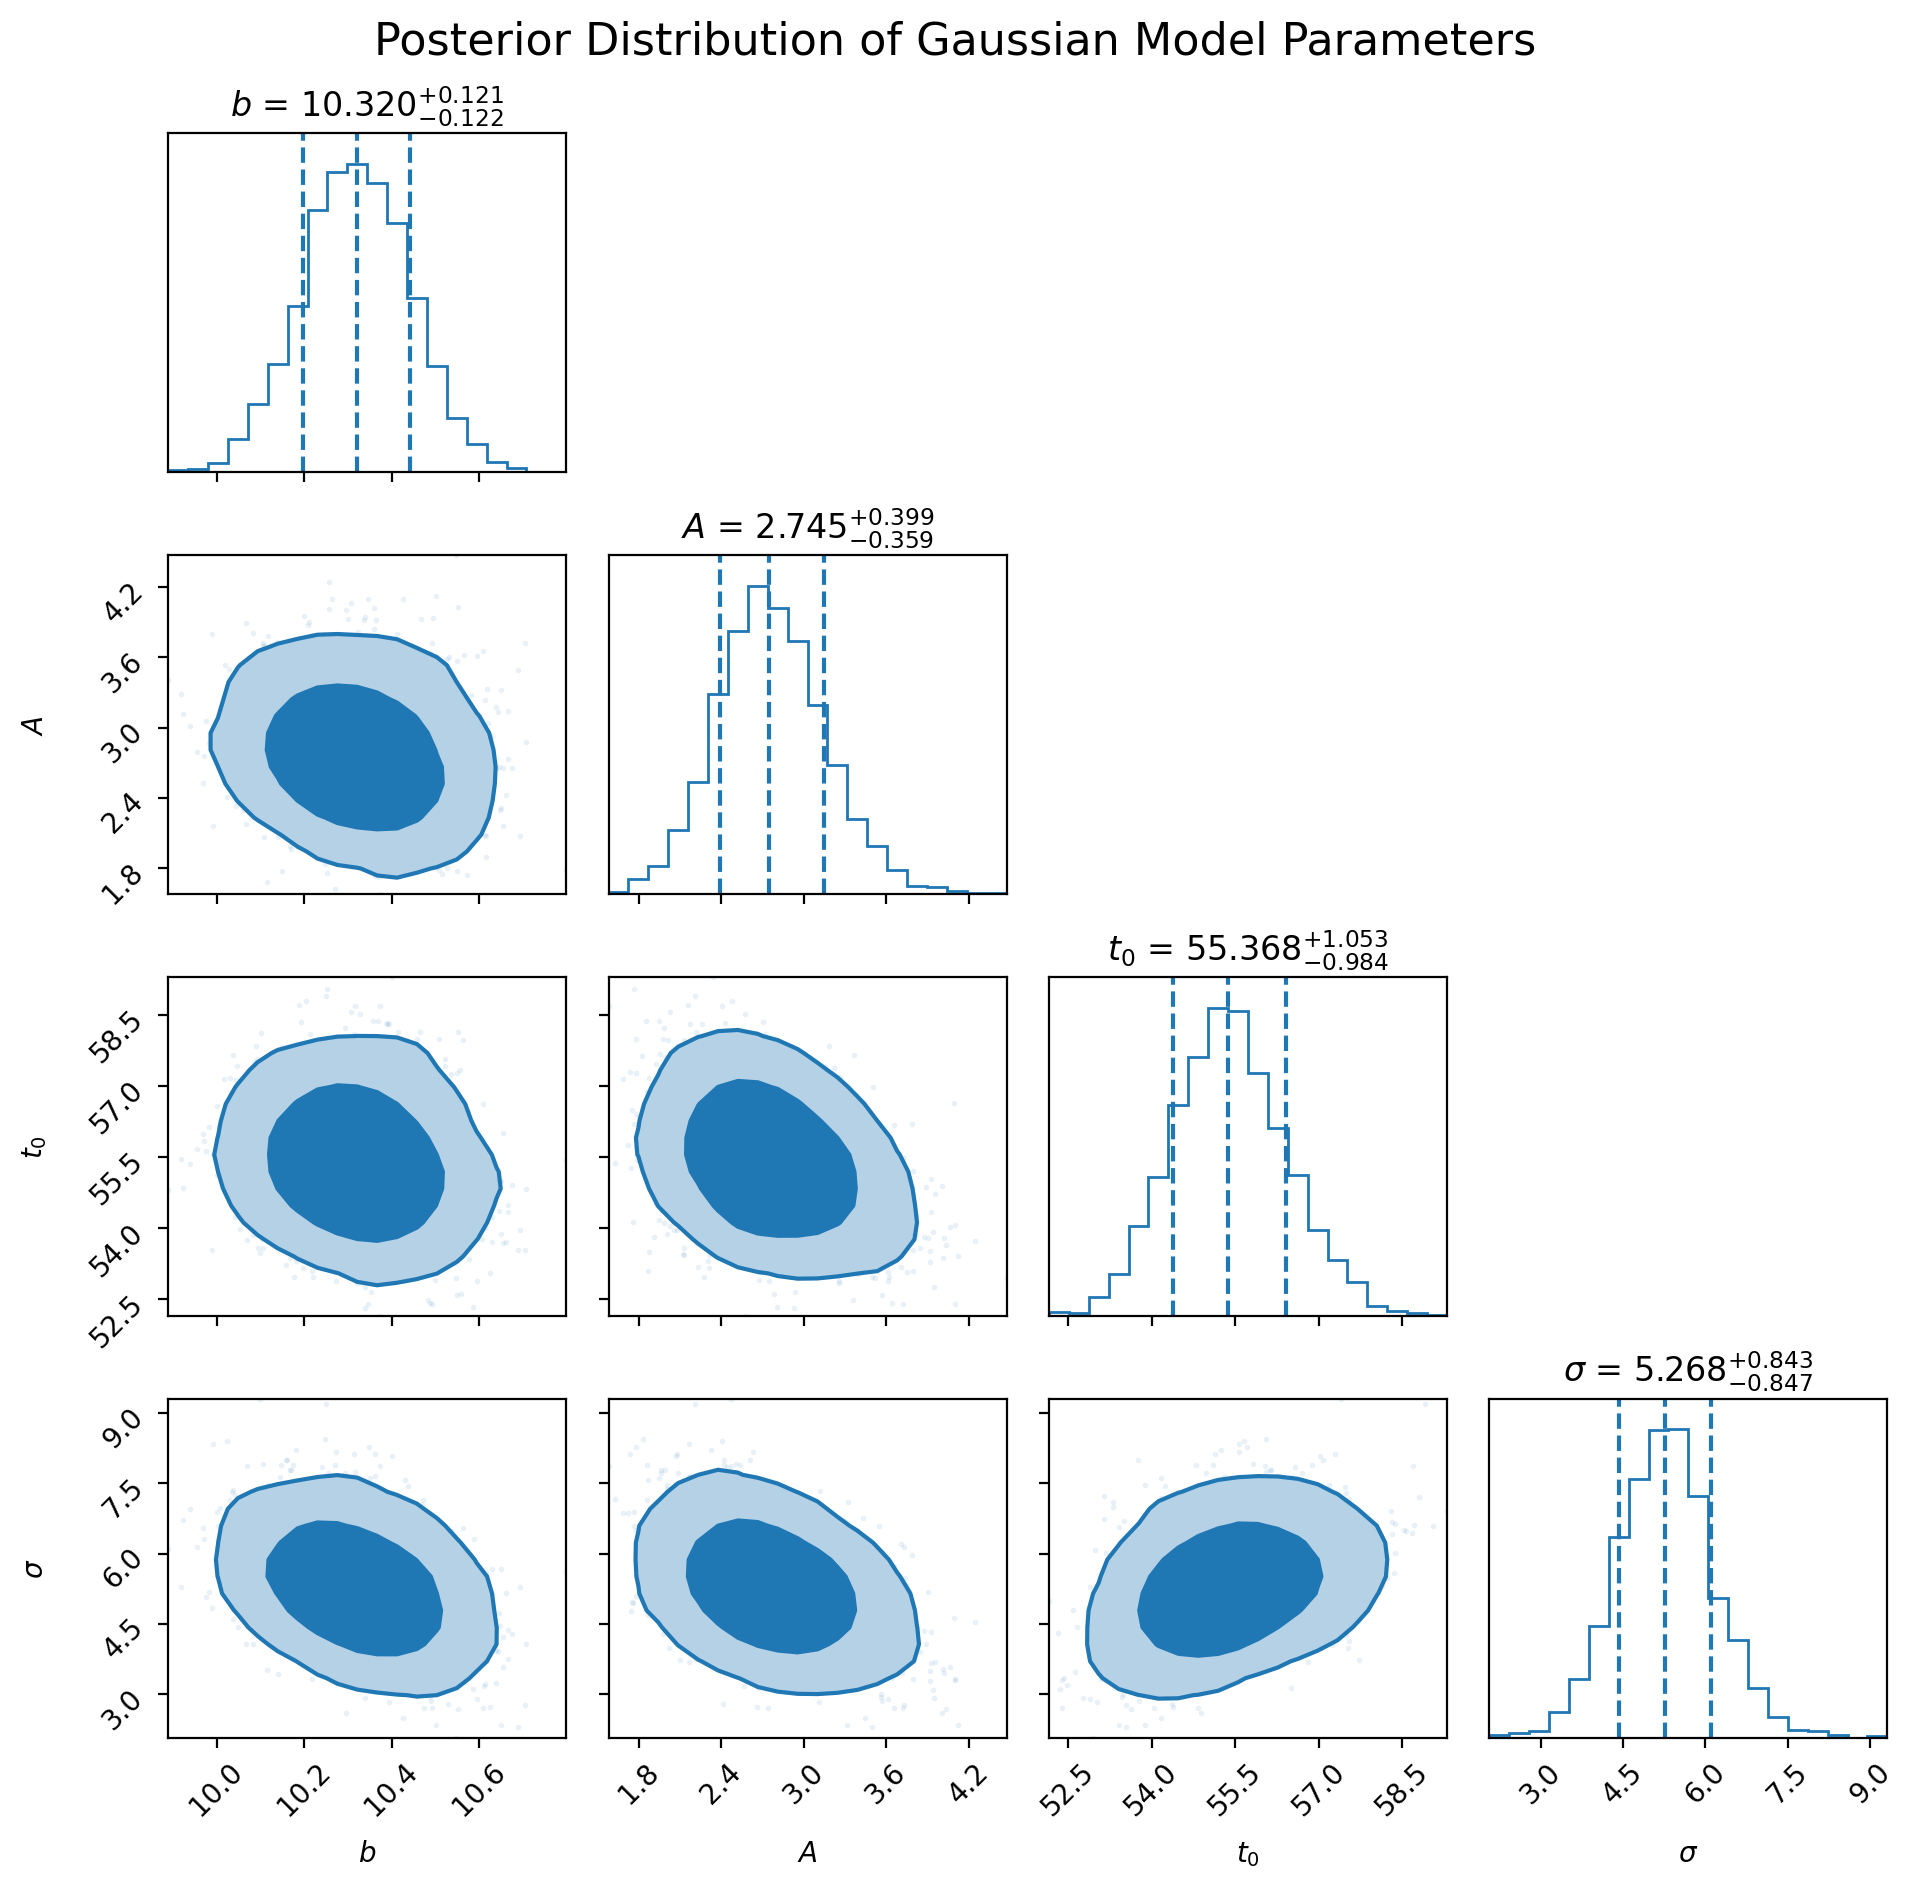

In [56]:
samples_with_sigma = samples_gaussian.copy()
samples_with_sigma[:, 3] = np.exp(samples_with_sigma[:, 3])

fig = corner.corner(
    samples_with_sigma,
    labels=[r"$b$", r"$A$", r"$t_0$", r"$\sigma$"],
    quantiles=[0.16, 0.5, 0.84],  # 16%, 50% (median), and 84% quantiles
    show_titles=True,
    title_kwargs={"fontsize": 12},
    title_fmt=".3f",
    levels=[0.68, 0.95],  # 68% and 95% credible levels
    smooth=1.0,
    plot_datapoints=True,
    plot_density=True,
    fill_contours=True,
    color='#1f77b4',
  )

fig.suptitle("Posterior Distribution of Gaussian Model Parameters", fontsize=16)
plt.tight_layout()

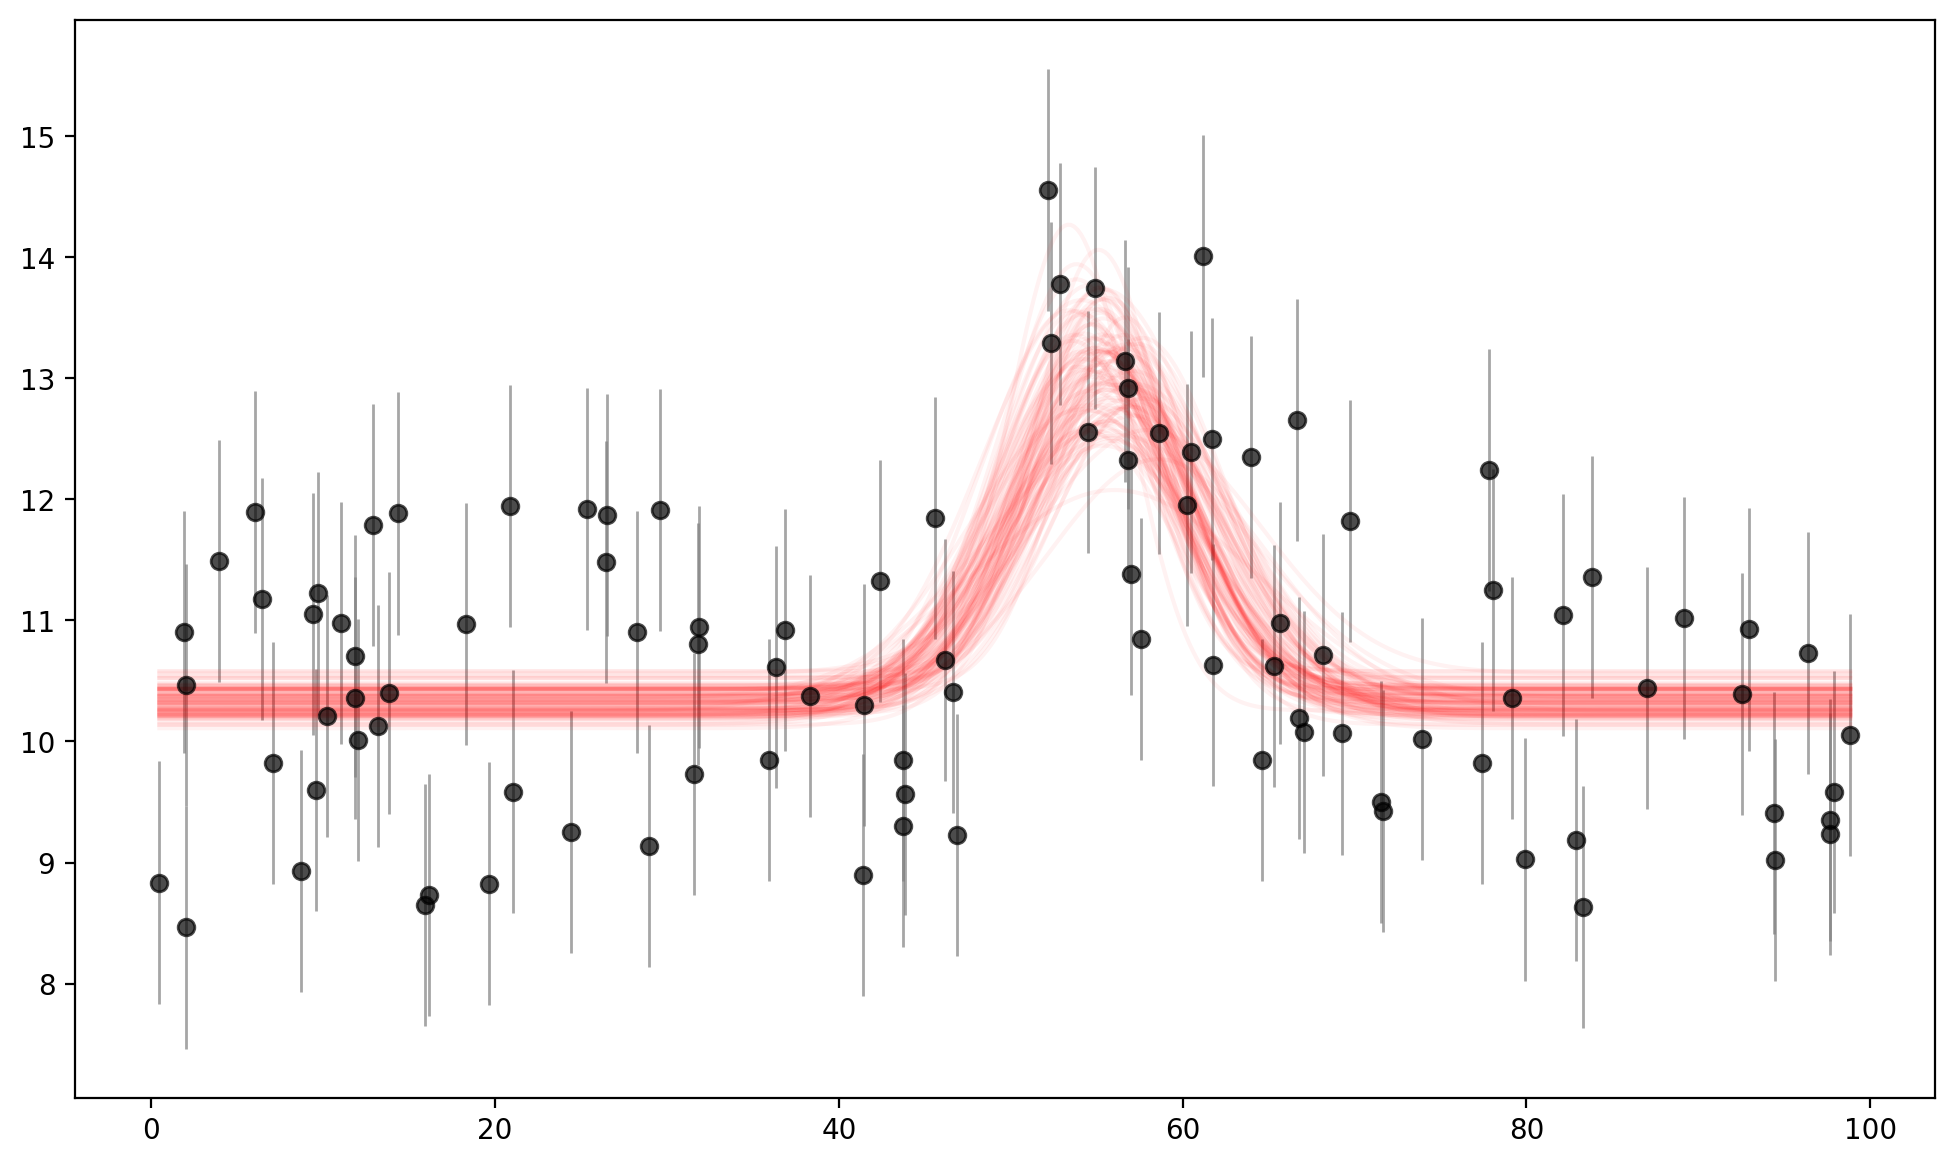

In [57]:
random_indices = np.random.choice(len(samples_gaussian), 100, replace=False)

plt.figure(figsize=(12, 7))

plt.errorbar(t, I, yerr=yerr, fmt='o', color='black',
             ecolor='gray', elinewidth=1, capsize=0, alpha=0.7,
             label='Data with uncertainties')

for idx in random_indices:
    params = samples_with_sigma[idx].copy()
    model_intensity = gaussian_model(t_model, params)
    plt.plot(t_model, model_intensity, color='red', alpha=0.05)

# Add a single red line for the legend
plt.plot([], [], color='red', alpha=0.5, label='Posterior model samples')